In [1]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour, watershed
from skimage.feature import peak_local_max

## Function 1

In [2]:
def snake(img, init):
    return active_contour(gaussian(img, 3, preserve_range=False),
                           init, alpha=0.015, beta=10, gamma=0.001)

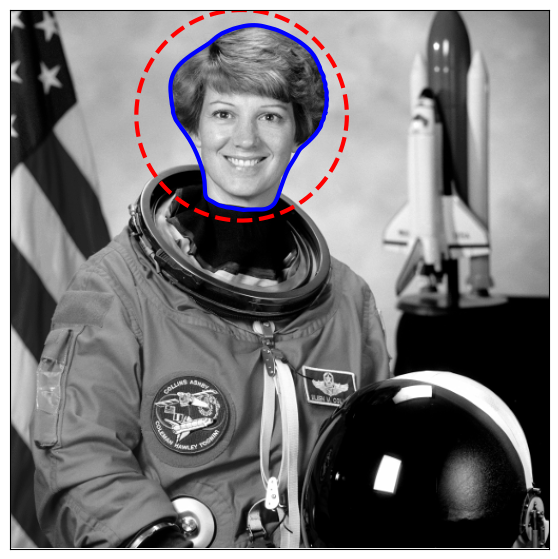

In [3]:
s = np.linspace(0, 2*np.pi, 400)

r = 100 + 100*np.sin(s)
c = 220 + 100*np.cos(s)
init = np.array([r, c]).T
img = data.astronaut()
img = rgb2gray(img)
snaked_image = snake(img, init)
fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(img, cmap=plt.cm.gray)
# Note: -- là đường đứt đoạn
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snaked_image[:, 1], snaked_image[:, 0], 'b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()


## Function 2

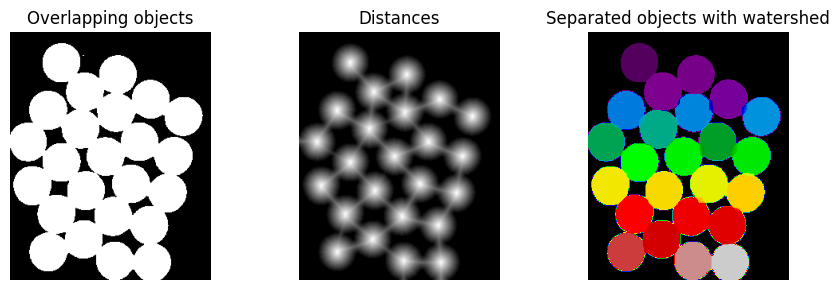

In [4]:
from skimage.filters import threshold_otsu
# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
# Read the image using cv2
image = cv2.imread('./image/coin2.jpg', cv2.IMREAD_GRAYSCALE)

# Perform thresholding and convert image to binary form
threshold_value = threshold_otsu(image)
image = image < threshold_value

def my_watershed(image):
    global distance
    distance = ndi.distance_transform_edt(image)
    coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    return watershed(-distance, markers, mask=image), distance

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(my_watershed(image)[1], cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(my_watershed(image)[0], cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects with watershed')

# remove axis
for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

## Function 3

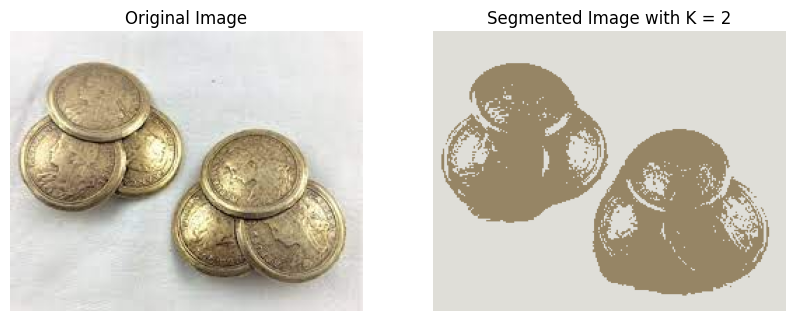

In [5]:
from sklearn.cluster import KMeans
import cv2

def kmeans_segmentation(image, num_clusters):
    # Reshape the image to a 2D array of pixels
    pixels = image.reshape(-1, 3).astype(np.float32)
    
    # Apply K-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centroids = cv2.kmeans(pixels, num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Convert centroid values to uint8
    centroids = np.uint8(centroids)
    
    # Assign each pixel to the nearest cluster centroid
    segmented_image = centroids[labels.flatten()].reshape(image.shape)
    
    return segmented_image


# Example usage
image = cv2.imread('./image/coin.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform K-means segmentation
num_clusters = 2 # Number of clusters
segmented_image = kmeans_segmentation(image, num_clusters)

# Display the original image and the segmented image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(segmented_image)
axes[1].set_title('Segmented Image with K = 2')
axes[1].axis('off')

plt.show()

## Function 4

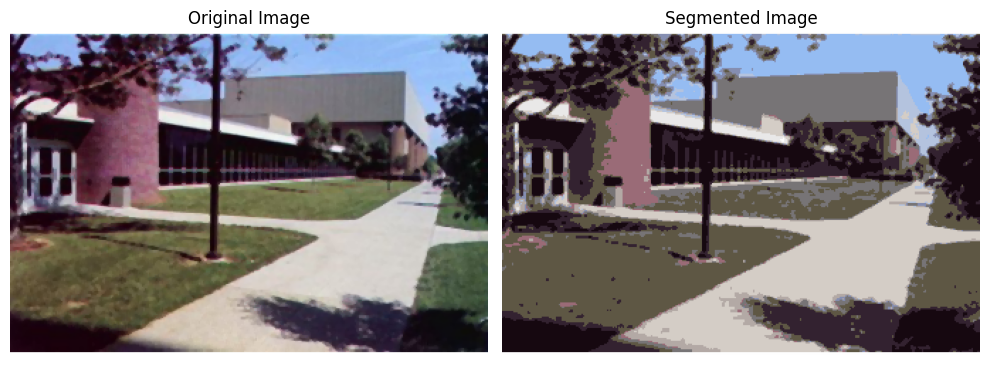

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth

def mean_shift_segmentation(image_path, quantile=0.06, n_samples=3000, max_iter=800):
    # Read the image
    img = cv2.imread(image_path)
    img = cv2.medianBlur(img, 3)
    flat_image = img.reshape((-1, 3))
    flat_image = np.float32(flat_image)


    bandwidth = estimate_bandwidth(flat_image, quantile=quantile, n_samples=n_samples)
    ms = MeanShift(bandwidth=bandwidth, max_iter=max_iter, bin_seeding=True)
    ms.fit(flat_image)
    labeled = ms.labels_

    segments = np.unique(labeled)
    total = np.zeros((segments.shape[0], 3), dtype=float)
    count = np.zeros(total.shape, dtype=float)
    for i, label in enumerate(labeled):
        total[label] = total[label] + flat_image[i]
        count[label] += 1
    avg = total / count
    avg = np.uint8(avg)
    res = avg[labeled]
    result = res.reshape((img.shape))
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Segmented Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

mean_shift_segmentation('./image/picture.png')